<a href="https://colab.research.google.com/github/Aru-14/AICTE_Internship_Garbage_Collection/blob/main/Week%201/GarbageCollection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr



In [2]:
dataset_dir=r"/content/drive/MyDrive/TrashType_Image_Dataset"
image_size = (224,224)
batch_size = 32
seed= 42

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
val_class = val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take(val_batches // 5)
val_dat = val_ds.skip(val_batches // 5)

test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [6]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


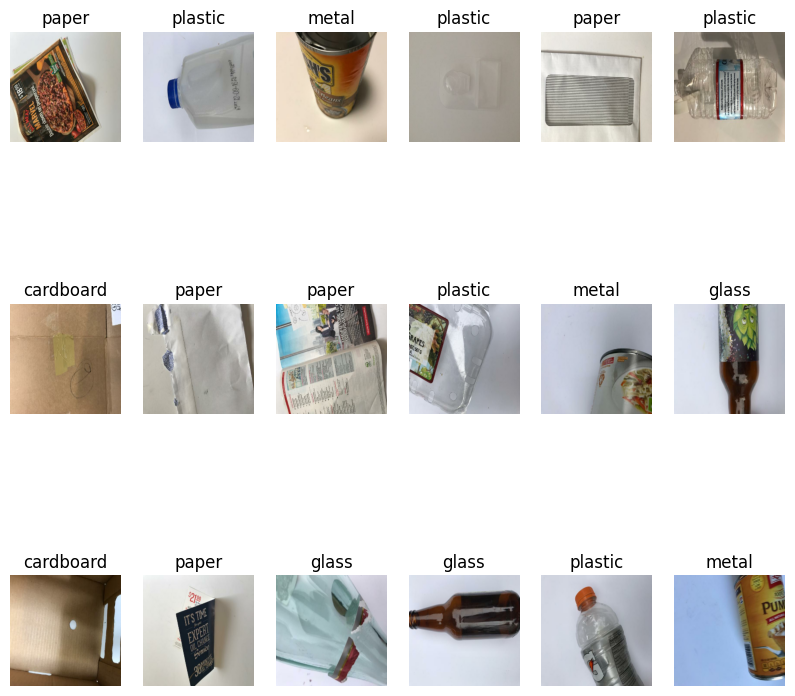

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(2):
  for i in range(18):
    ax = plt.subplot(3,6,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


In [8]:
def count_distribution(dataset, class_names):
  total = 0
  counts = {name: 0 for name in class_names}

  for _, labels in dataset:
    for label in labels.numpy():
      class_name = class_names[int(label)]
      counts[class_name] += 1
      total += 1

  for k in counts:
    counts[k] = round((counts[k]/total)*100,2)

  return counts

In [9]:
def simple_bar_plot(dist, title):
  plt.bar(dist.keys(), dist.values(), color = "salmon")
  plt.title(title)
  plt.ylabel('Percentage (%)')
  plt.xticks(rotation = 50)
  plt.ylim(0, 100)
  plt.tight_layout()
  plt.show()

In [12]:
class_names = train_ds.class_names

train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
  overall_dist[k] = round((train_dist[k] + val_dist[k])/2,2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

KeyboardInterrupt: 

In [ ]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [ ]:
class_counts = {i:0 for i in range(len(class_names))}
all_labels=[]

for images, labels in train_ds:
  for label in labels.numpy():
    class_counts[int(label)] += 1
    all_labels.append(int(label))

class_weights_array = compute_class_weight(
    class_weight = "balanced",
    classes = np.arange(len(class_names)),
    y = all_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2)
])

In [ ]:
base_model = EfficientNetV2B2(include_top= False, input_shape=(224,224,3),include_preprocessing=True, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable = False

In [ ]:
model = Sequential([
    layers.Input(shape=(224,224,3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

In [ ]:
model.compile(
    optimizer = optimizers.Adam(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 3,
    restore_best_weights=True

)

In [ ]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    class_weight = class_weights,
    callbacks = [early]
)